In [371]:
import process_data
from process_data import get_dfs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit  
from scipy.special import voigt_profile
from scipy.ndimage import gaussian_filter1d
import os
import importlib
importlib.reload(process_data)

<module 'process_data' from '/Users/xnimir/Desktop/Sn exp 2024/process_data.py'>

In [372]:
def gaussian(x, A, mu, sigma, B):
    return A * np.exp(-((x - mu)**2) / (2 * sigma**2)) + B

In [373]:
def standard_lorentzian(x, amplitude, center, width, offset):
    return amplitude * width**2 / ((x - center)**2 + width**2) + offset

In [374]:
def super_lorentzian(x, amplitude, center, width, power, offset):
    # Generalized Lorentzian with adjustable power for wider wings
    return amplitude * width**power / ((x - center)**power + width**power) + offset

In [375]:
def modified_voigt(x, amplitude, center, g_width, l_width, offset, slope, modification_factor, transition_point):
    basic_voigt = amplitude * voigt_profile(x - center, g_width, l_width)
    wing_enhancement = modification_factor * amplitude * (g_width**2 / ((x - center)**2 + g_width**2))**0.5
    baseline = offset + slope * np.maximum(0, x - transition_point)
    return basic_voigt + wing_enhancement + baseline

In [376]:
def gaus_fitting(x,y):
    x_fit = np.linspace(np.min(x), np.max(x), 500)

    initial_guess = [np.max(y), x[np.argmax(y)], np.std(x), 0]
    bounds = ([0, 0, 0, 0], [np.inf, np.max(x), np.inf, np.inf])
    popt, pcov = curve_fit(gaussian, x, y, p0=initial_guess, bounds=bounds, sigma=np.sqrt(y), absolute_sigma=True)
    y_fit = gaussian(x_fit, *popt)

    fwhm = 2.355 * popt[2] * 1E6
    fit_errors_g = np.sqrt(np.diag(pcov))
    mu_error = fit_errors_g[1]

    return x_fit, y_fit, popt, pcov, fwhm

In [377]:
def voigt_fitting(x,y):
    x_fit = np.linspace(np.min(x), np.max(x), 500)

    amplitude = np.max(y)
    center = x[np.argmax(y)]

    # half_max = amplitude / 2
    # indices_above_half_max = np.where(y >= half_max)[0]
    # if len(indices_above_half_max) > 1:
    #     fwhm = x[indices_above_half_max[-1]] - x[indices_above_half_max[0]]
    #     g_width = fwhm / (2 * np.sqrt(2 * np.log(2)))  # Convert FWHM to standard deviation
    # else:
    #     g_width = (x[-1] - x[0]) / 10  # Fallback: estimate width as a fraction of x range
    g_width = 200E-6 / (2 * np.sqrt(2 * np.log(2)))
    l_width = g_width / 2  # Start with l_width smaller than g_width
    offset = np.min(y)
    slope = 50000
    modification_factor = 0.1
    transition_point = 0.005

    # lower_bounds = [0, np.min(x), 0, 0, -np.inf, 0]  # Amplitude >= 0
    # upper_bounds = [np.inf, np.max(x), np.max(x) - np.min(x), np.max(x) - np.min(x), np.inf, 1]  # No tight upper bounds


    popt, pcov = curve_fit(modified_voigt, x, y, 
                           p0=[amplitude, center, g_width, l_width, offset, slope, modification_factor, transition_point])
                            # bounds=(lower_bounds, upper_bounds))
    
    y_fit = modified_voigt(x_fit, *popt)

    g_width_fit = popt[2]  # Extract Gaussian width from popt
    l_width_fit = popt[3]  # Extract Lorentzian width from popt
    fwhm = np.sqrt(g_width_fit**2 + l_width_fit**2) * 1E6

    return x_fit, y_fit, popt, pcov, fwhm

In [378]:
def get_scatter_plot(data_df, time_df, freq_df, file):
    x = data_df['Bin center']
    y = data_df['Count raw']
    # y_1 = gaussian_filter1d(data_df['Count raw'], sigma=2)
    # y = data_df['Total_count']
    # y_norm = data_df['Norm count']
    x_fit_g, y_fit_g, popt_g, pcov_g, fwhm_g = gaus_fitting(x, y)
    x_fit_v, y_fit_v, popt_v, pcov_v, fwhm_v = voigt_fitting(x, y)
    

    plt.figure()
    # plt.errorbar(x, y, yerr=np.sqrt(y), fmt='o', capsize=3)
    plt.scatter(x,y)
    # plt.plot(x_fit_g, y_fit_g, color='green', label = 'G')
    plt.plot(x_fit_v, y_fit_v, color='red', label = 'V')
    plt.title(f'{file}')
    plt.xlabel('frequency (THz)')
    plt.ylabel('binned counts')
    # plt.legend()

    # label_g = f'Gaussian: mu={popt_g[1]:.6f} THz\nfwhm={fwhm_g:.2f} MHz'
    # plt.text(0.95, 0.95, label_g, fontsize=10,
    #                     verticalalignment='top', horizontalalignment='right',
    #                     transform=plt.gca().transAxes) 
    
    label_v = f'mu={popt_v[1]:.6f} THz\nfwhm={fwhm_v:.2f} MHz'
    plt.text(0.95, 0.95, label_v, fontsize=10,
                        verticalalignment='top', horizontalalignment='right',
                        transform=plt.gca().transAxes) 
    plt.show()

    # plt.title('Frequency')
    # plt.scatter(freq_df['Bin center'], freq_df['Count raw'], color='red')
    # plt.show()
    # plt.title('Time')
    # plt.scatter(time_df['Bin center'], time_df['Count raw'])
    # plt.show()

    # return popt_g[1], fwhm

In [379]:
def main(folder_path):
    for filename, scaled_df, time_df, freq_df in get_dfs(folder_path):
        get_scatter_plot(scaled_df, time_df, freq_df, filename)

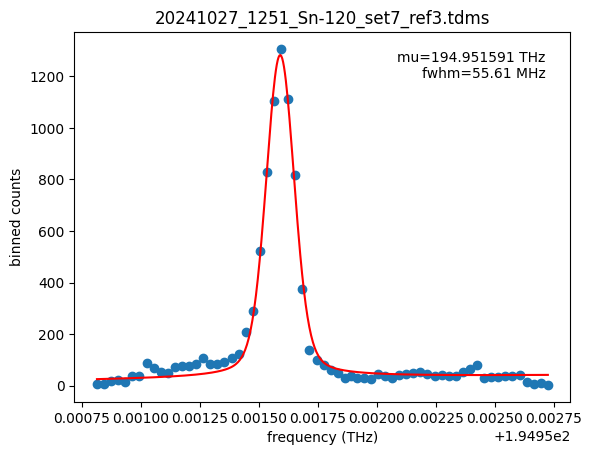

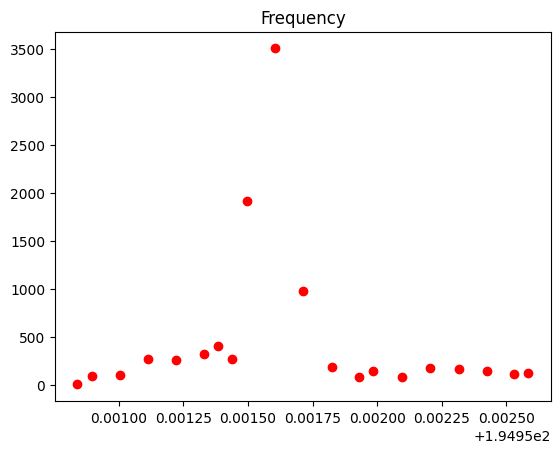

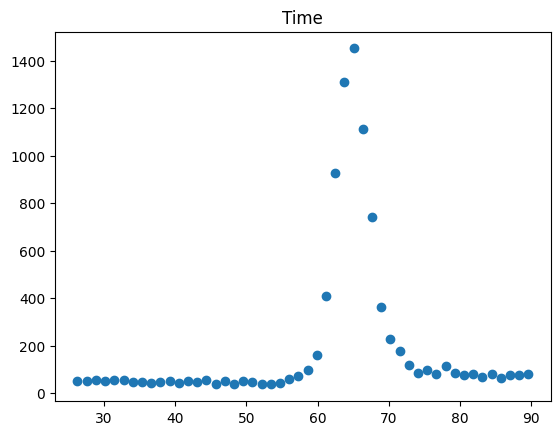

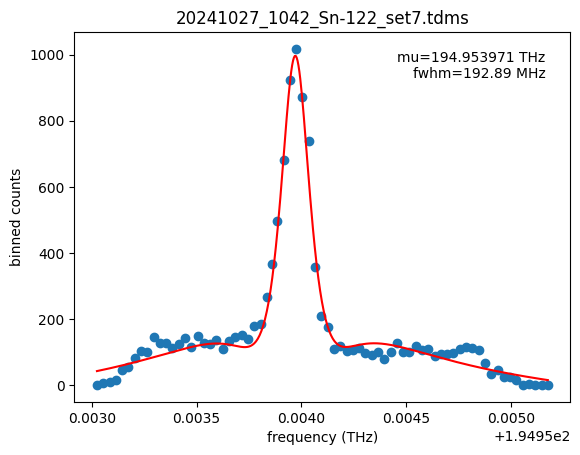

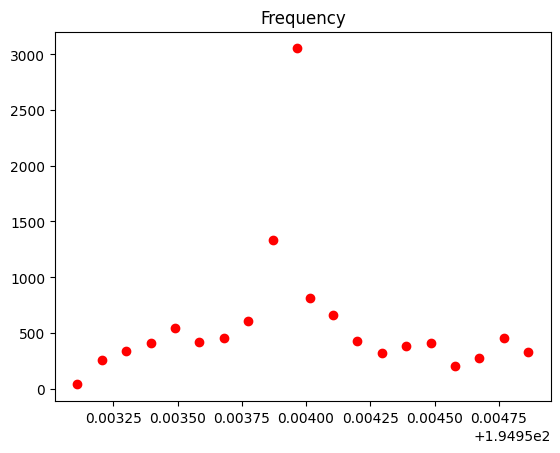

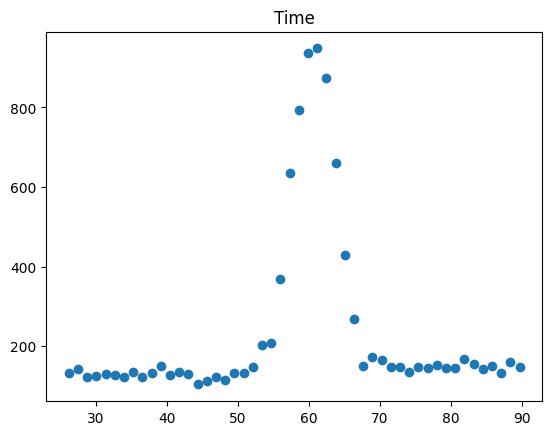

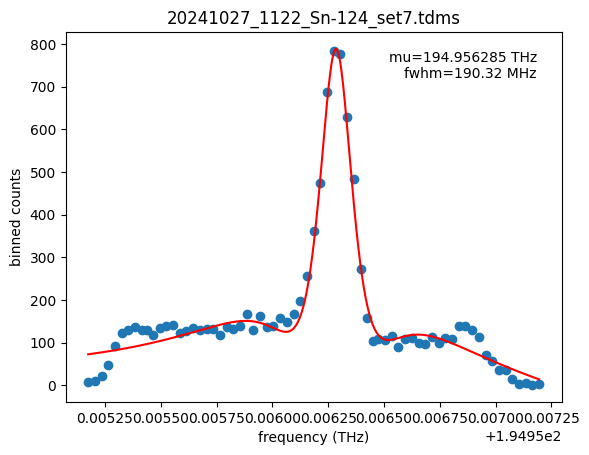

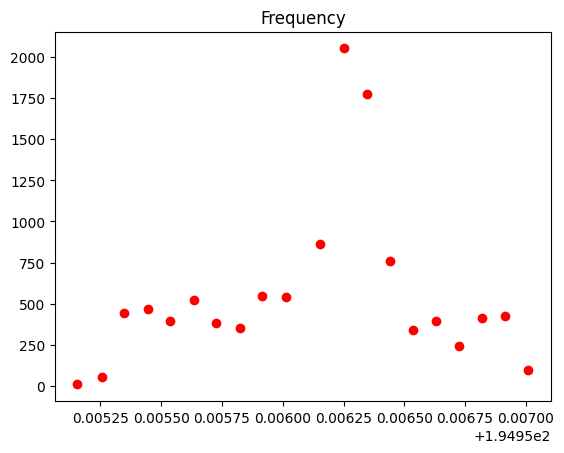

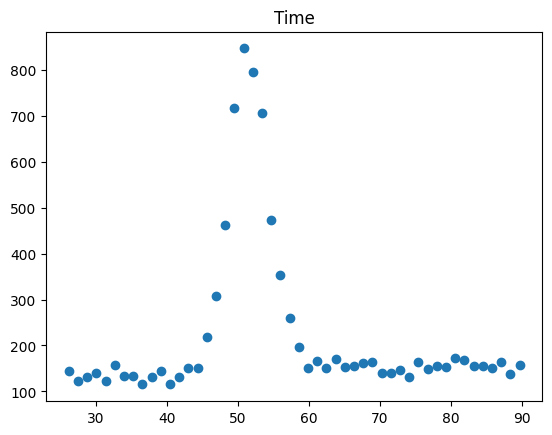

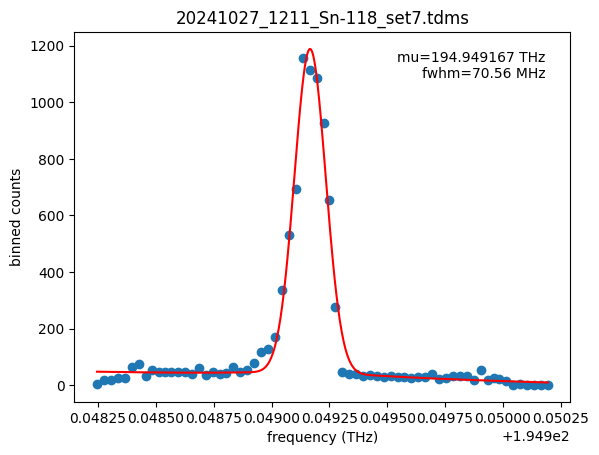

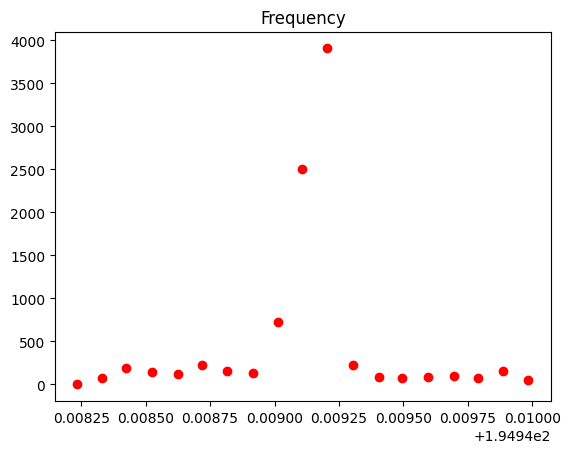

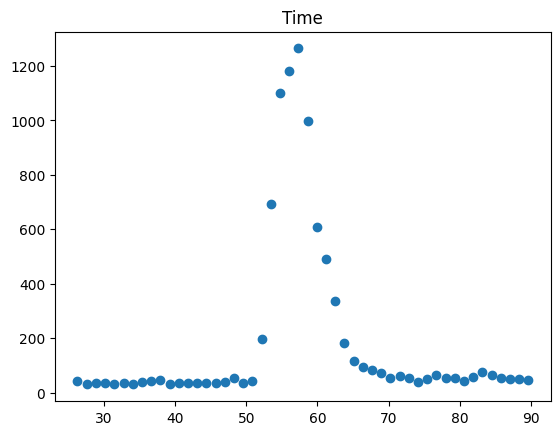

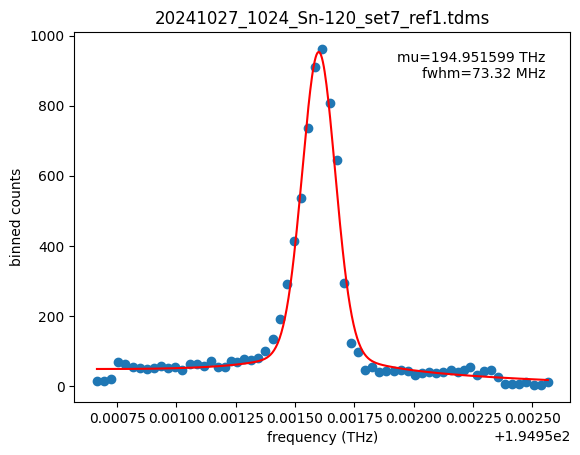

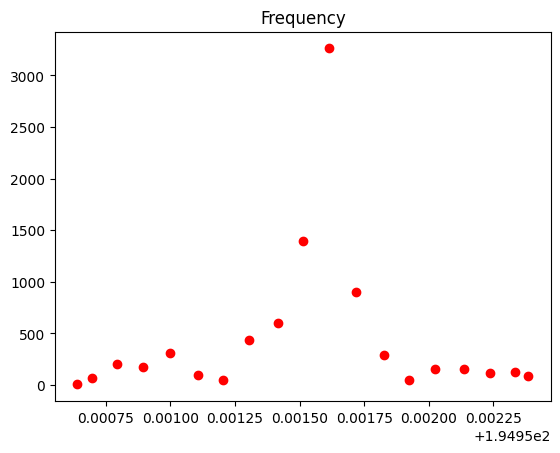

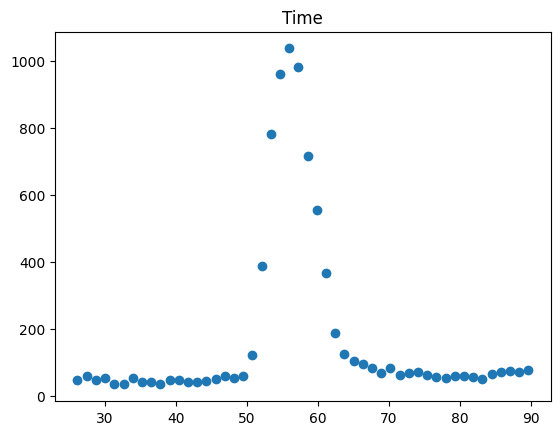

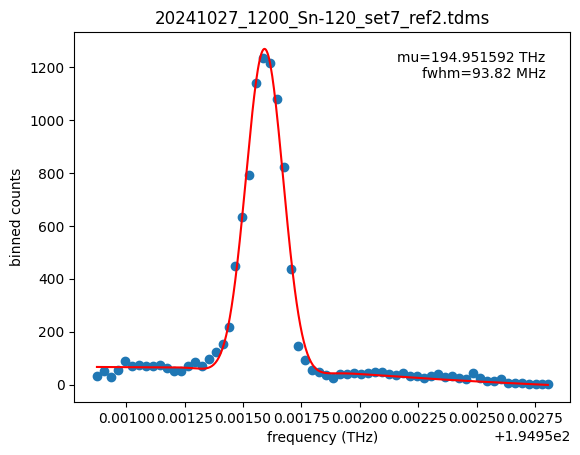

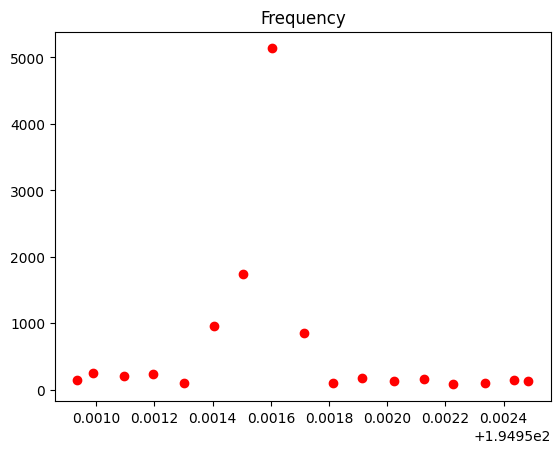

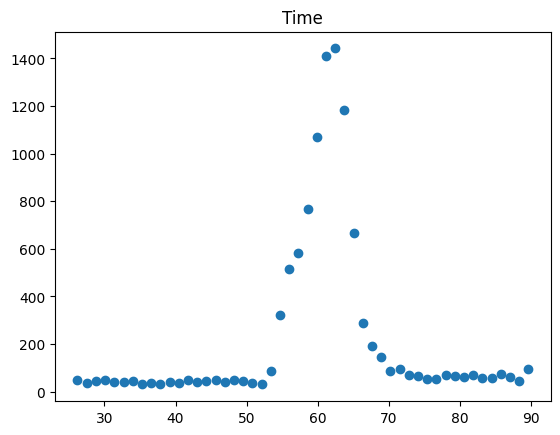

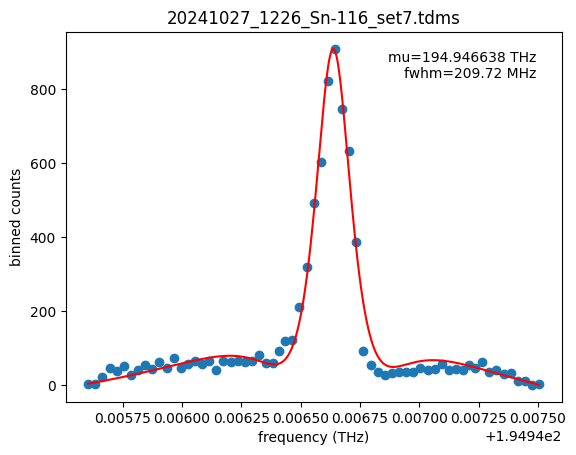

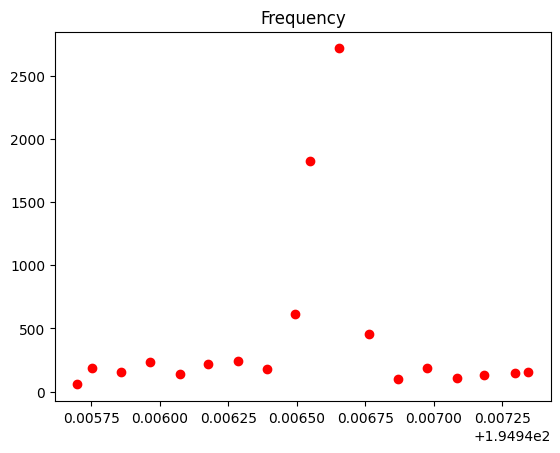

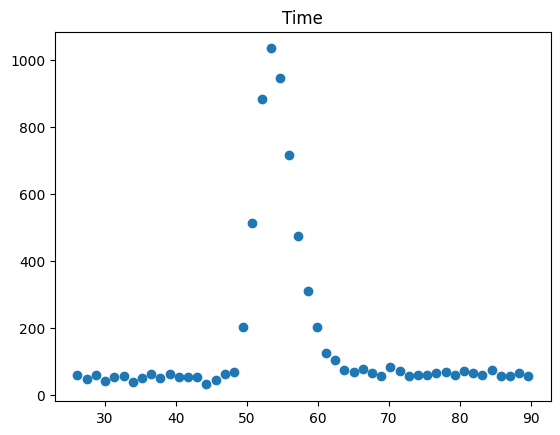

In [380]:
def single_set():
    folder_path = '/Users/xnimir/Desktop/Sn exp 2024/data/set7/'
    main(folder_path)
single_set()